# USC CSCI 567 HW3

Author: Thamme Gowda N  
USCID: 2074669439

In [14]:
from __future__ import print_function
import random
import numpy as np
from matplotlib import pyplot as plt

/Users/thammegr/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Bias Variance Trade-of

In [106]:
# Generate random data
def uniform_randoms(start, end, count):
    return [random.uniform(start, end) for _ in range(count)]

def generate_datasets(start, end, count, sets):
    return np.array([uniform_randoms(start, end, count) for _ in range(sets)])

# define f(x) 
def f(x, e=None):
    if e is None:
        e = random.gauss(0.0, 0.1)
    return 2 * x * x + e

def generate_ys(datasets):
    yss = []
    for xs in datasets:
        ys =[f(x) for x in xs]
        yss.append(ys)
    return np.array(yss)


In [129]:
def predict(X, W):
    return np.matmul(X, W)

def MSECost(Y2, Y1):
    return float(np.sum((Y2 - Y1) ** 2) / len(Y2))

def fit_line(X, Y):
    return np.matmul(
        np.matmul(
            np.linalg.pinv(np.matmul(X.transpose(), X)),
            X.transpose()),
        Y)

class LinearRegression(object):
    
    def __init__(self, X, Y):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)
        X = self.normalize(X)
        self.W = fit_line(X, Y)
    
    def normalize(self, X):
        X = (X - self.means) / self.stds
        # Bias is added as a weight to simplify the calculations
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def predict(self, X):
        
        X = self.normalize(X)
        return np.matmul(X, self.W)

highest_poly_deg = 4
def report_bias_variance(sample_size, num_ds):
    datasets = generate_datasets(-1, 1, sample_size, num_ds)
    yss = generate_ys(datasets)

    plt.figure(1, figsize=(16, 24))
    # G1 is constant, no learning required, thus no regression 
    costs = np.zeros(num_ds)
    for i in range(num_ds): 
        Y =  yss[i]
        predY = np.array([1.0 for _ in range(len(Y))])
        costs[i] = MSECost(Y, predY)

    plt.subplot(4, 2, 1)
    plt.hist(costs, 10, facecolor='green', alpha=0.75)
    plt.xlabel('Mean Square Sum of errors')
    plt.ylabel('Counts')
    plt.title(r'$g_%d(x)=w^Tx$  $\mu=%f, \sigma=%f$.' % (1, costs.mean(), costs.std()))

    for j in range(highest_poly_deg + 1): # highest power of X
        print("Heighest power of X = ", j)
        costs = np.zeros(num_ds) 
        for i in range(num_ds): 
            n = len(datasets[0])
            X = np.zeros(shape=(n, 0))
            for power in range(1, j + 1):
                X = np.insert(X, X.shape[1], datasets[i] ** power, axis=1)
            Y =  yss[i]
            linreg = LinearRegression(X, Y)
            predY = linreg.predict(X)
            costs[i] = MSECost(Y, predY)

        plt.subplot(4, 2, 2 + j)
        plt.hist(costs, 10, facecolor='green', alpha=0.75)
        plt.xlabel('Mean Square Sum of errors')
        plt.ylabel('Counts')
        plt.title(r'$g_%d(x)=w^Tx$  $\mu=%f, \sigma=%f$.' % (j + 2, costs.mean(), costs.std()))

    plt.show()


Heighest power of X =  0
Heighest power of X =  1
Heighest power of X =  2
Heighest power of X =  3
Heighest power of X =  4


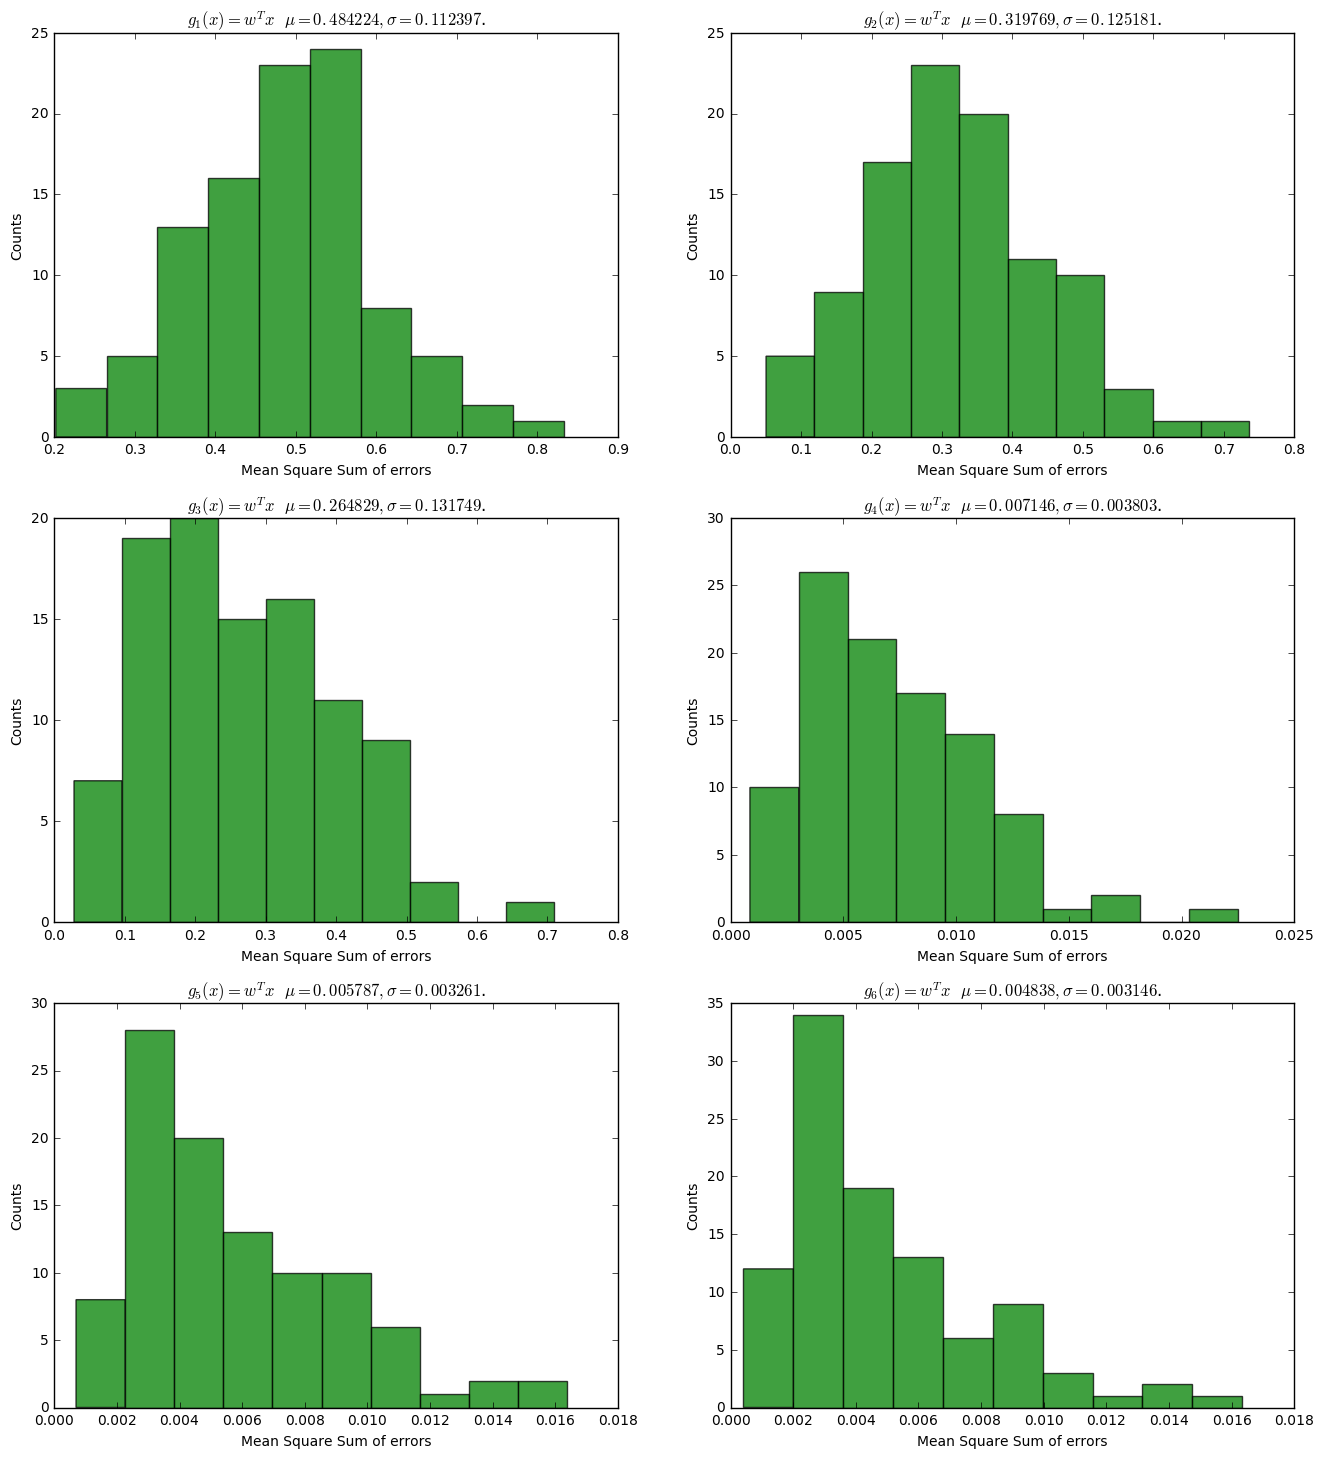

In [130]:
report_bias_variance(sample_size=10, num_ds=100)

Heighest power of X =  0
Heighest power of X =  1
Heighest power of X =  2
Heighest power of X =  3
Heighest power of X =  4


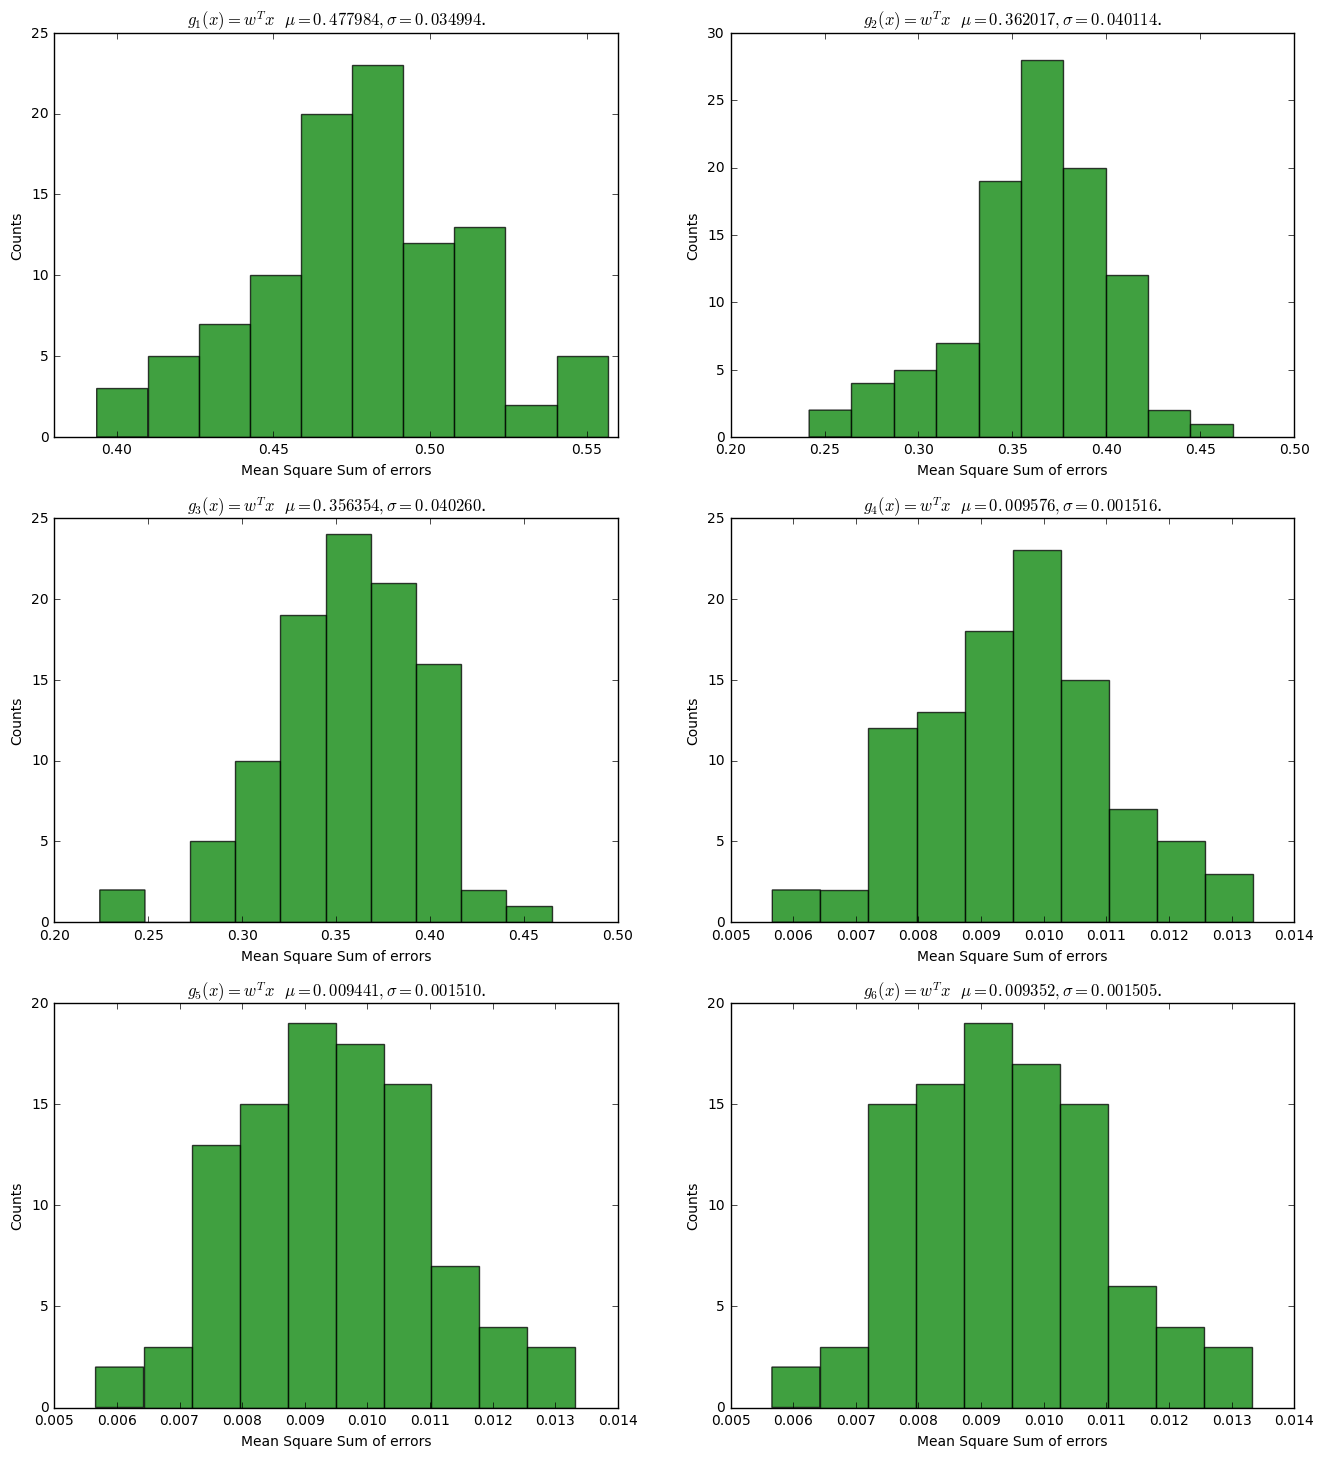

In [135]:
# Change sample size to 100
report_bias_variance(sample_size=100, num_ds=100)

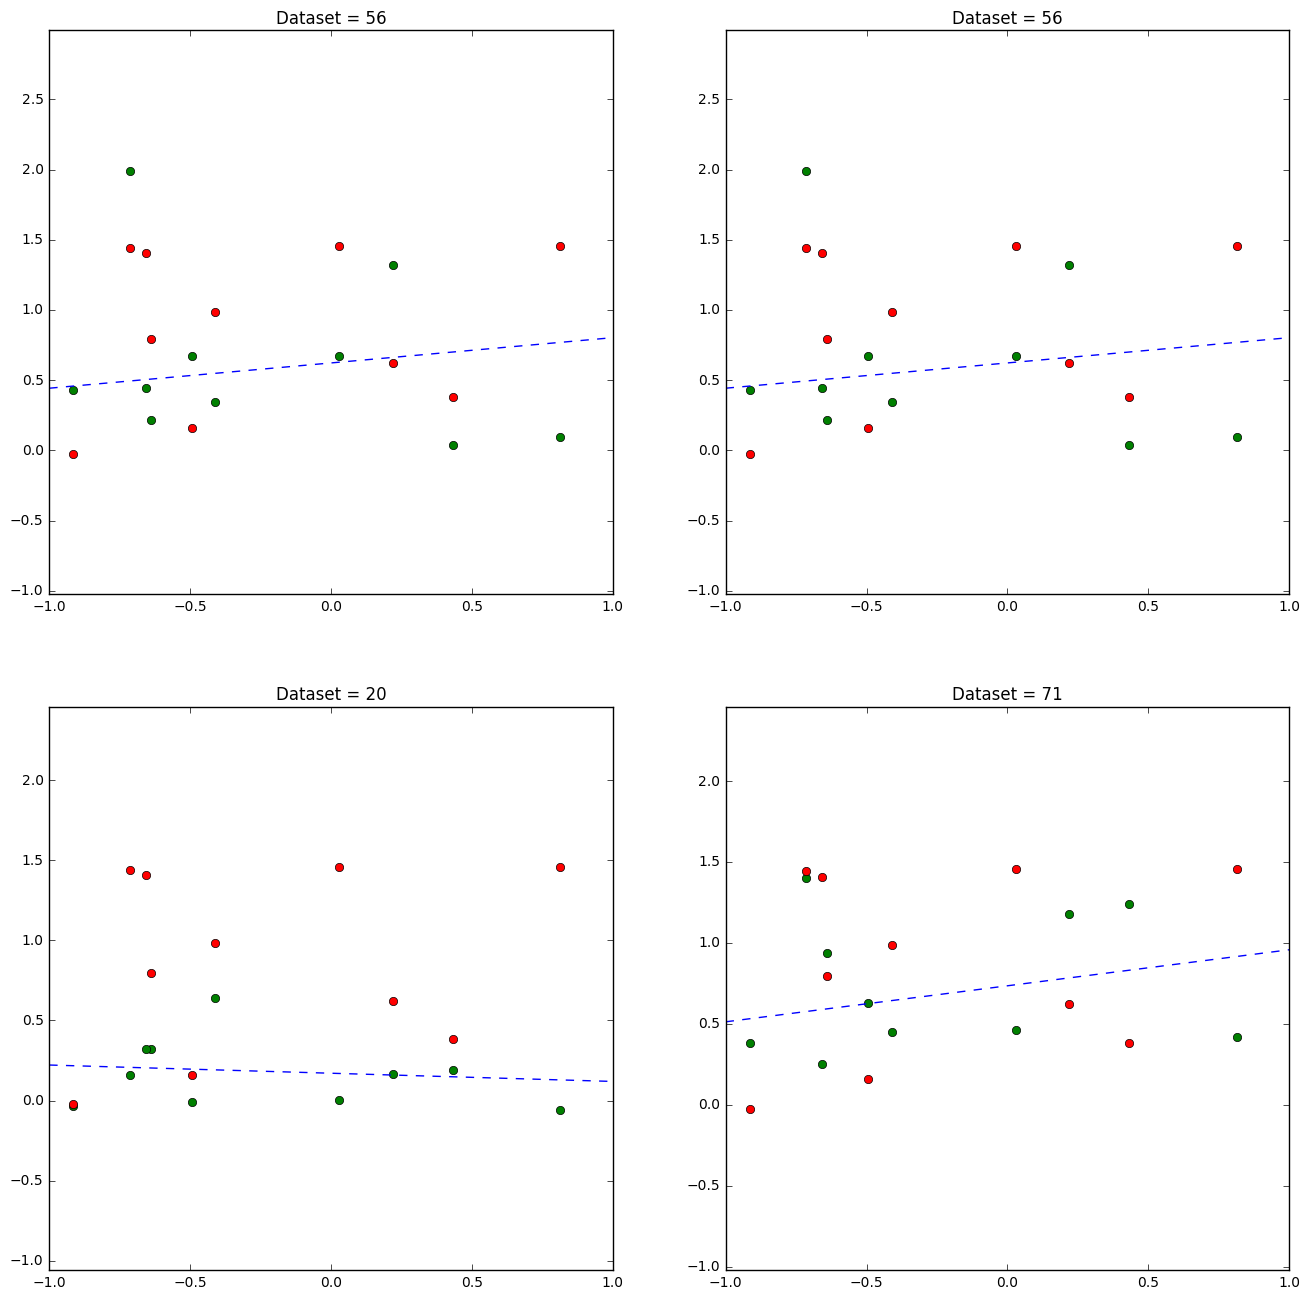

In [126]:
# To visualize lin regress line fitting
plt.figure(figsize=(16,16))
for j in range(4):
    i = random.randint(0, len(datasets))
    
    X = datasets[i].transpose().reshape((len(datasets[i]), 1))
    Y = yss[i]
    linreg = LinearRegression(X, Y)
    z = np.linspace(-1, 1)
    zz = linreg.W[1] * z + linreg.W[0]

    plt.subplot(2,2, 1 + j)
    plt.plot(datasets[0], Y, 'go', datasets[0], predY, 'ro', z, zz, '--')
    plt.xlim(-1, 1)
    plt.ylim(min(min(Y), min(predY)) - 1, max(max(Y), max(predY)) + 1)
    plt.title("Dataset = %d" % i)

plt.show()
